# Fashion MNIST Stacking + Unstacking

## Downloading the Data

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

In [8]:
data_folder = '../data/'
dataset_name = 'Fashion_MNIST'
dataset_folder = os.path.join(data_folder, dataset_name)

In [9]:
if os.path.exists(dataset_folder):
    print(f"Using existing dataset folder: {dataset_folder}")
    fashion_mnist_data = torchvision.datasets.FashionMNIST(data_folder, 
                                            train=True,
                                            transform=torchvision.transforms.ToTensor())
    # NOTE:
    # transform=torchvision.transforms.ToTensor(): Converts the PIL Image or NumPy array to a 
    # torch.FloatTensor and scales the pixel values to the range [0.0, 1.0].
else:
    print(f"Dataset folder '{dataset_folder}' does not exist. Downloading dataset...")
    fashion_mnist_data = torchvision.datasets.FashionMNIST(data_folder, 
                                            train=True,
                                            transform=torchvision.transforms.ToTensor(), 
                                            download=True)

Dataset folder '../data/Fashion_MNIST' does not exist. Downloading dataset...


### Checking the First 3 Images

First image shape: torch.Size([1, 28, 28])
First image label: 9


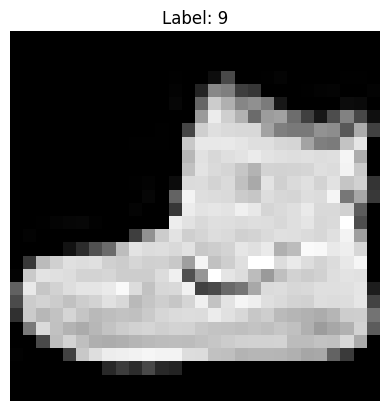

In [10]:
# Getting the first image in the dataset
first_image, first_label = fashion_mnist_data[0]
print("First image shape:", first_image.shape)
print("First image label:", first_label)
plt.imshow(first_image.squeeze(), cmap='gray')
plt.title(f"Label: {first_label}")
plt.axis('off')
plt.show()

Second image shape: torch.Size([1, 28, 28])
Second image label: 0


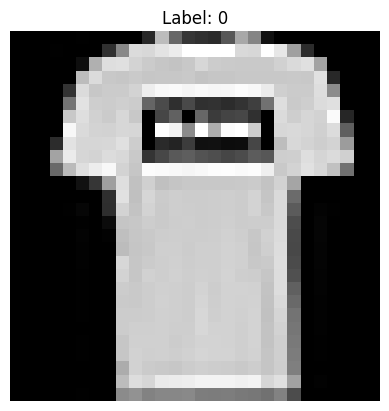

In [11]:
# Getting the second image in the dataset
second_image, second_label = fashion_mnist_data[1]
print("Second image shape:", second_image.shape)
print("Second image label:", second_label)
plt.imshow(second_image.squeeze(), cmap='gray')
plt.title(f"Label: {second_label}")
plt.axis('off')
plt.show()

Third image shape: torch.Size([1, 28, 28])
Third image label: 0


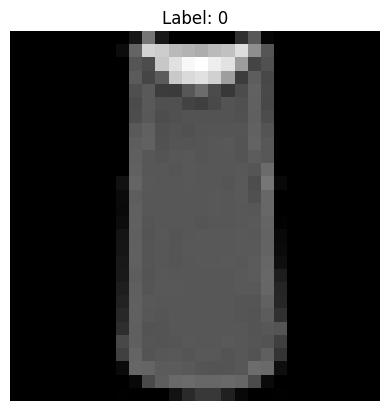

In [12]:
# Getting the third image in the dataset
third_image, third_label = fashion_mnist_data[2]
print("Third image shape:", third_image.shape)
print("Third image label:", third_label)
plt.imshow(third_image.squeeze(), cmap='gray')
plt.title(f"Label: {third_label}")
plt.axis('off')
plt.show()

## Stacking

### Stacking the First 3 Images

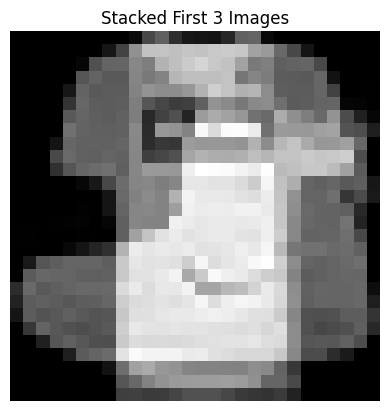

Stacked First 3 images shape: torch.Size([1, 28, 28])


In [ ]:
images = []

for i in range(3):
    image, label = fashion_mnist_data[i]
    images.append(image)

stacked = torch.stack(images) # Uses torch.stack to stack images along a new dimension
overlay_all = stacked.mean(dim=0) # Averages the stacked images to create an overlay effect

plt.imshow(overlay_all.squeeze(), cmap='gray') # Squeeze to remove single-dimensional entries (turns [1, 28, 28] to [28, 28])
plt.title("Stacked First 3 Images")
plt.axis('off')
plt.show()

print("Stacked First 3 images shape:", overlay_all.shape)

## CNN Classes and Functions

In [ ]:
transform = transforms.ToTensor() # Transform to convert images to tensor
fashion_mnist_train = datasets.FashionMNIST(root='.', train=True, download=True, transform=transform) # Training dataset

In [ ]:
# Custom Dataset to overlay pairs of images from the base dataset and return the original images
class OverlayDataset(Dataset):
    """
    Returns:
        overlay: overlayed image (1, 28, 28)
        imgA: first original image (1, 28, 28)
        imgB: second original image (1, 28, 28)
    """
    def __init__(self, base_dataset, num_pairs=None):
        self.base = base_dataset # base dataset
        self.num_pairs = num_pairs if num_pairs else len(base_dataset) - 1 # number of pairs of images

    def __len__(self):
        return self.num_pairs # length of dataset

    def __getitem__(self, idx):
        imgA, _ = self.base[idx] # first image
        imgB, _ = self.base[idx + 1] # second image
        overlay = (imgA + imgB) / 2.0 # overlay by averaging
        return overlay, imgA, imgB # return overlay and original images

In [ ]:
# Shows the results of the model on the overlay dataset
def show_overlay_results(model, dataset, index=0):
    """
    Display:
    - Overlay input
    - Original images A and B
    - Predicted images A and B
    """
    model.eval() # set model to evaluation mode
    
    # Get overlay and original images
    overlay, imgA, imgB = dataset[index]
    
    # Add batch dimension and move to device
    overlay_batch = overlay.unsqueeze(0).to(next(model.parameters()).device) # unsqueeze to add batch dimension, move to model device
    
    with torch.no_grad(): # no gradient calculation
        predA, predB = model(overlay_batch)
        predA = predA.squeeze().cpu()
        predB = predB.squeeze().cpu()
    
    # Plot
    plt.figure(figsize=(8,4))
    
    # plots the combined image
    plt.subplot(1,5,1)
    plt.imshow(overlay.squeeze(), cmap='gray')
    plt.title("Overlay")
    plt.axis('off')
    
    # plots the original first image
    plt.subplot(1,5,2)
    plt.imshow(imgA.squeeze(), cmap='gray')
    plt.title("Original A")
    plt.axis('off')
    
    # plots the original second image
    plt.subplot(1,5,3)
    plt.imshow(imgB.squeeze(), cmap='gray')
    plt.title("Original B")
    plt.axis('off')
    
    # plots the predicted first image
    plt.subplot(1,5,4)
    plt.imshow(predA, cmap='gray')
    plt.title("Predicted A")
    plt.axis('off')
    
    # plots the predicted second image
    plt.subplot(1,5,5)
    plt.imshow(predB, cmap='gray')
    plt.title("Predicted B")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN with residual connections for separating overlayed images
class ResidualSeparatorCNN(nn.Module):
    def __init__(self):
        super().__init__() # call parent constructor
        
        # Initial conv
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1) # input channels=1, output channels=64, kernel size=3
        self.bn1 = nn.BatchNorm2d(64) # batch normalization, stabilizes learning and speeds up convergence

        # Residual block 1, handles simple features
        self.res1_conv1 = nn.Conv2d(64, 128, 3, padding=1) # increase channels to 128 to learn complex features
        self.res1_bn1 = nn.BatchNorm2d(128) # batch normalization, stabilizes learning and speeds up convergence
        self.res1_conv2 = nn.Conv2d(128, 64, 3, padding=1) # reduce channels back to 64 so addition is possible
        self.res1_bn2 = nn.BatchNorm2d(64) # batch normalization, stabilizes learning and speeds up convergence
        
        # Residual block 2, handles more complex features
        self.res2_conv1 = nn.Conv2d(64, 128, 3, padding=1) # increase channels to 128 to learn complex features
        self.res2_bn1 = nn.BatchNorm2d(128) # batch normalization, stabilizes learning and speeds up convergence
        self.res2_conv2 = nn.Conv2d(128, 64, 3, padding=1) # reduce channels back to 64 so addition is possible
        self.res2_bn2 = nn.BatchNorm2d(64) # batch normalization, stabilizes learning and speeds up convergence
        
        # Branch for first image (which combination of features reconstructs the first image)
        self.branchA = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1), # reduce channels to 32 for reconstruction
            nn.ReLU(), # allows the network to learn non-linear combinations of features
            nn.Conv2d(32, 1, 3, padding=1), # final output channel is 1 (grayscale image)
            nn.Sigmoid() # ensures output pixel values are between 0 and 1, suitable for Fashion-MNIST images
        )
        
        # Branch for second image (which combination of features reconstructs the second image)
        self.branchB = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1), # reduce channels to 32 for reconstruction
            nn.ReLU(), # allows the network to learn non-linear combinations of features
            nn.Conv2d(32, 1, 3, padding=1), # final output channel is 1 (grayscale image)
            nn.Sigmoid() # ensures output pixel values are between 0 and 1, suitable for Fashion-MNIST images
        )
    
    # Forward pass
    def forward(self, x):
        # Initial conv
        out = F.relu(self.bn1(self.conv1(x))) # 64 channel feature map for combination of features
        
        # Residual block 1, handles simple features
        res = F.relu(self.res1_bn1(self.res1_conv1(out))) # increase channels to 128 to learn complex features
        res = self.res1_bn2(self.res1_conv2(res)) # reduce channels back to 64 so addition is possible
        out = F.relu(out + res)  # residual connection, helps with gradient flow and learning identity mappings
        
        # Residual block 2, handles more complex features
        res = F.relu(self.res2_bn1(self.res2_conv1(out))) # increase channels to 128 to learn complex features
        res = self.res2_bn2(self.res2_conv2(res)) # reduce channels back to 64 so addition is possible
        out = F.relu(out + res)  # residual connection, helps with gradient flow and learning identity mappings
        
        # Branch outputs
        outA = self.branchA(out) # decode first image from combined features
        outB = self.branchB(out) # decode second image from combined features
        
        return outA, outB

In [ ]:
overlay_dataset = OverlayDataset(fashion_mnist_train, num_pairs=10000) # overlay dataset with 10,000 pairs of combined images
dataloader = DataLoader(overlay_dataset, batch_size=32, shuffle=True) # prepares data for training in batches, shuffles for randomness

In [ ]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu' # use MPS if available, else CPU
model = ResidualSeparatorCNN().to(device) # initialize model and move to device
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # Adam optimizer (commonly used for CNNs), learning rate 0.001 to ensure stable training

In [ ]:
# Separation loss function using L1 loss
def separation_loss_l1(predA, predB, imgA, imgB):
    loss1 = F.l1_loss(predA, imgA) + F.l1_loss(predB, imgB) # calculate L1 loss assuming predA corresponds to imgA and predB to imgB
    loss2 = F.l1_loss(predA, imgB) + F.l1_loss(predB, imgA) # calculate L1 loss assuming predA corresponds to imgB and predB to imgA
    return torch.min(loss1, loss2) # return the minimum loss to handle permutation ambiguity

## Training

In [ ]:
num_epochs = 15  # number of training epochs, sees all batches 15 times

for epoch in range(num_epochs): # training loop
    running_loss = 0.0 # initialize running loss for the epoch, keeps track of total loss
    for overlay, imgA, imgB in dataloader: # iterate over batches
        overlay = overlay.to(device) # move overlay to device
        imgA = imgA.to(device) # move imgA to device
        imgB = imgB.to(device) # move imgB to device

        w = torch.rand(overlay.size(0), 1, 1, 1, device=device) * 0.2 + 0.4  # random weight between 0.4 and 0.6 for blending
        overlay_rand = w * imgA + (1 - w) * imgB # create random weighted overlay

        optimizer.zero_grad() # clear previous gradients
        predA, predB = model(overlay_rand) # forward pass, get predicted images from model
        loss = separation_loss_l1(predA, predB, imgA, imgB) # compute loss between predictions and original images
        loss.backward() # backward pass, compute gradients of loss w.r.t. model parameters
        optimizer.step() # optimize weights, update model parameters

        running_loss += loss.item() # accumulate loss
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}") # print average loss for the epoch

Epoch 1/15, Loss: 0.2662
Epoch 2/15, Loss: 0.2612
Epoch 3/15, Loss: 0.2611
Epoch 4/15, Loss: 0.2603
Epoch 5/15, Loss: 0.2619
Epoch 6/15, Loss: 0.2602
Epoch 7/15, Loss: 0.2589
Epoch 8/15, Loss: 0.2613
Epoch 9/15, Loss: 0.2604
Epoch 10/15, Loss: 0.2604
Epoch 11/15, Loss: 0.2611
Epoch 12/15, Loss: 0.2592
Epoch 13/15, Loss: 0.2582
Epoch 14/15, Loss: 0.2615
Epoch 15/15, Loss: 0.2619


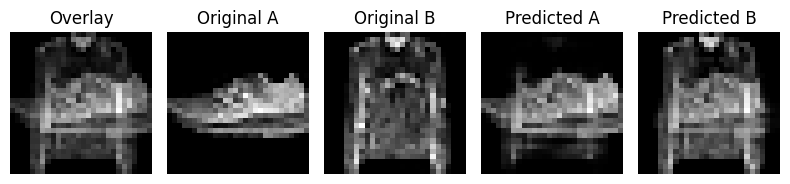

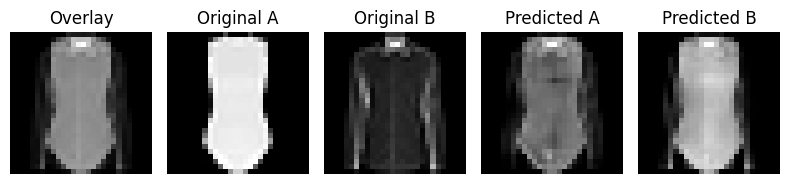

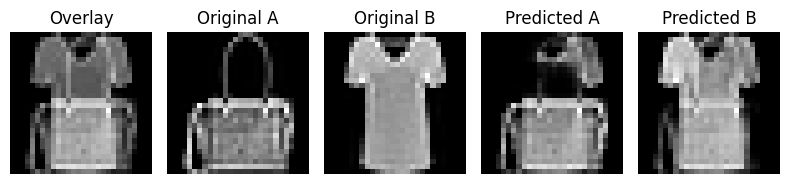

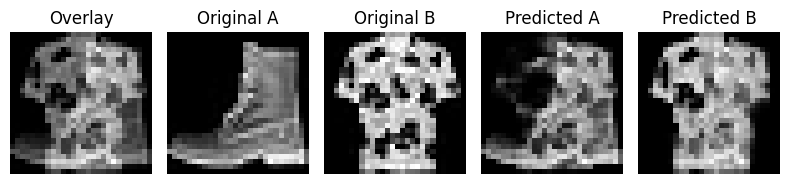

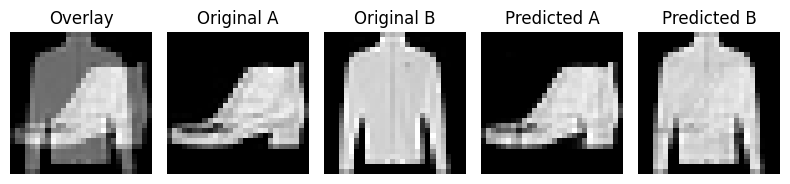

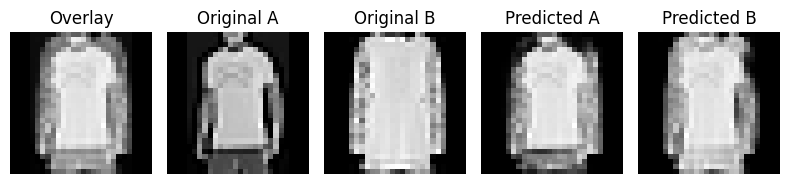

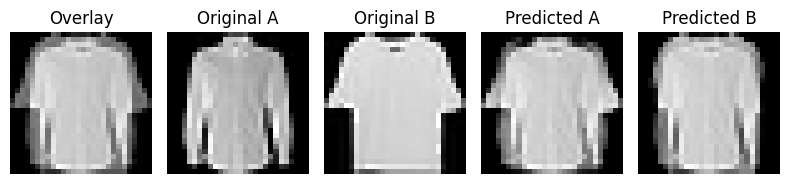

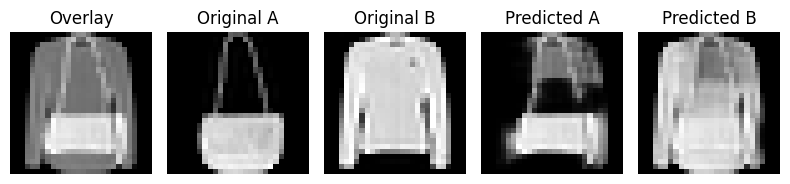

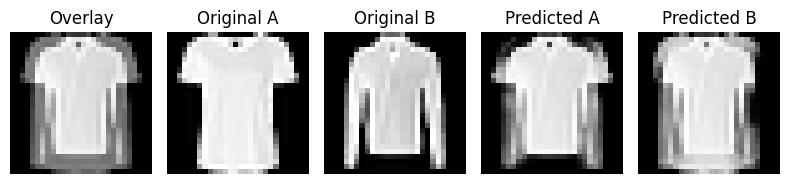

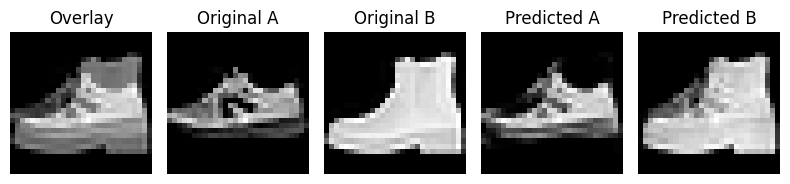

In [41]:
# Show overlay results for 10 random samples
import random
for _ in range(10):
    rand_index = random.randint(0, len(overlay_dataset) - 1)
    show_overlay_results(model, overlay_dataset, index=rand_index)